# Sparse regression

In this example we will use a sparse binary regression with hierarchies on the scale of the independent variable’s parameters that function as a proxy for variable selection. We will use the Horseshoe prior to {cite:p}`carvalho2010horseshoe` to ensure sparsity.

The Horseshoe prior consists in putting a prior on the scale of the regression parameter $\beta$: the product of a global $\tau$ and local $\lambda$ parameter that are both concentrated at $0$, thus allowing the corresponding regression parameter to degenerate at $0$ and effectively excluding this parameter from the model. This kind of model is challenging for samplers: the prior on $\beta$'s scale parameter creates funnel geometries that are hard to efficiently explore {cite:p}`papaspiliopoulos2007general`.

Mathematically, we will consider the following model:

\begin{align*}
\tau &\sim \operatorname{C}^+(0, 1)\\
\boldsymbol{\lambda} &\sim \operatorname{C}^+(0, 1)\\
\boldsymbol{\beta} &\sim \operatorname{Normal}(0, \tau \lambda)\\
\\
p &= \operatorname{sigmoid}\left(- X.\boldsymbol{\beta}\right)\\
y &\sim \operatorname{Bernoulli}(p)\\
\end{align*}

The model is run on its *non-centered parametrization* {cite:p}`papaspiliopoulos2007general` with data from the numerical version of the German credit dataset. The target posterior is defined by its likelihood. We implement the model using [Aesara](https://github.com/aesara-devs/aesara):

In [1]:
import aesara.tensor as at

X_at = at.matrix('X')

srng = at.random.RandomStream(0)

tau_rv = srng.halfcauchy(0, 1)
lambda_rv = srng.halfcauchy(0, 1, size=X_at.shape[-1])

sigma = tau_rv * lambda_rv
beta_rv = srng.normal(0, sigma, size=X_at.shape[-1])

eta = X_at @ beta_rv
p = at.sigmoid(-eta)
Y_rv = srng.bernoulli(p, name="Y")

```{note}
The non-centered parametrization is not necessarily adapted to every geometry. One should always check *a posteriori* the sampler did not encounter any funnel geomtry.
```

## German credit dataset

We will use the sparse regression model on the German credit dataset {cite:p}`dua2017machine`. We use the numeric version that is adapted to models that cannot handle categorical data:

In [2]:
import pandas as pd

data = pd.read_table(
  "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric",
  header=None,
  delim_whitespace=True
)

Each row in the dataset corresponds to a different customer. The dependent variable $y$ is equal to $1$ when the customer has good credit and $2$ when it has bad credit; we encode it so a customer with good credit corresponds to $1$, a customer with bad credit $1$:

In [3]:
y = -1 * (data.iloc[:, -1].values - 2)

In [4]:
r_bad = len(y[y==0.]) / len(y)
r_good = len(y[y>1]) /  len(y)

print(f"{r_bad*100}% of the customers in the dataset are classified as having bad credit.")

30.0% of the customers in the dataset are classified as having bad credit.


The regressors are defined on different scales so we normalize their values, and add a column of $1$ that corresponds to the intercept:

In [5]:
import numpy as np

X = (
    data.iloc[:, :-1]
    .apply(lambda x: -1 + (x - x.min()) * 2 / (x.max() - x.min()), axis=0)
    .values
)
X = np.concatenate([np.ones((1000, 1)), X], axis=1)

## Models

We generate a function that computes the model's logdensity using [AePPL](https://github.com/aesara-devs/aeppl). We transform the values of $\tau$ and $\lambda$ so the sampler can operate on variables defined on the real line:

In [6]:
import aesara
import aeppl
from aeppl.transforms import TransformValuesRewrite, LogTransform

transforms_op = TransformValuesRewrite(
     {lambda_rv: LogTransform(), tau_rv: LogTransform()}
)

logdensity, value_variables = aeppl.joint_logprob(
    tau_rv,
    lambda_rv,
    beta_rv,
    realized={Y_rv: at.as_tensor(y)},
    extra_rewrites=transforms_op
)


logdensity_aesara_fn = aesara.function([X_at] + list(value_variables), logdensity, mode="JAX")

def logdensity_fn(x):
    tau = x['log_tau']
    lmbda = x['log_lmbda']
    beta = x['beta']
    return logdensity_aesara_fn.vm.jit_fn(X, tau, lmbda, beta)[0]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/functools.py:888: UserWarning: Skipping `CheckAndRaise` Op (assertion: sigma > 0) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)
/opt/hostedtoolcache/Python/3.9.16/x64/lib/python3.9/functools.py:888: UserWarning: Skipping `CheckAndRaise` Op (assertion: 0 <= p <= 1) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)


Let us now define a utility function that builds a sampling loop:

In [7]:
import jax

def inference_loop(rng_key, init_state, kernel, n_iter):
    keys = jax.random.split(rng_key, n_iter)

    def step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

### MEADS

The MEADS algorithm {cite:p}`hoffman2022tuning` is a combination of Generalized HMC with a parameter tuning procedure. Let us initialize the position of the chain first:

In [8]:
num_chains = 128
num_warmup = 2000
num_samples = 2000

rng_key = jax.random.PRNGKey(10)
rng_key, key_b, key_l, key_t = jax.random.split(rng_key, 4)
init_position = {
    "beta": jax.random.normal(key_b, (num_chains, X.shape[1])),
    "log_lmbda": jax.random.normal(key_l, (num_chains, X.shape[1])),
    "log_tau": jax.random.normal(key_t, (num_chains,)),
}

Here we will not use the adaptive version of the MEADS algorithm, but instead use their heuristics as an adaptation procedure for Generalized Hamiltonian Monte Carlo kernels:

In [9]:
import blackjax

key_warmup, key_sample = jax.random.split(rng_key)
meads = blackjax.meads_adaptation(logdensity_fn, num_chains)
(state, parameters), _ = meads.run(key_warmup, init_position, num_warmup)
kernel = blackjax.ghmc(logdensity_fn, **parameters).step

# Choose the last state of the first two chains as a starting point for the sampler
init_states = jax.tree_util.tree_map(lambda x: x[:2], state)
keys = jax.random.split(rng_key, 2)
samples, info = jax.vmap(inference_loop, in_axes=(0, 0, None, None))(keys, init_states, kernel, num_samples)

Let us look a high-level summary statistics for the inference, including the split-Rhat value and the number of effective samples:

In [10]:
from numpyro.diagnostics import print_summary

print_summary(samples.position)


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta[0]     -0.26      0.33     -0.19     -0.74      0.22     45.94      1.06
      beta[1]     -0.81      0.12     -0.80     -1.02     -0.64     74.73      1.01
      beta[2]      1.21      0.28      1.22      0.74      1.64     74.57      1.01
      beta[3]     -0.71      0.17     -0.73     -1.00     -0.44     92.76      1.06
      beta[4]      0.20      0.28      0.15     -0.19      0.62     36.80      1.00
      beta[5]     -0.41      0.13     -0.41     -0.60     -0.20     63.17      1.01
      beta[6]     -0.20      0.14     -0.19     -0.40      0.02     61.47      1.01
      beta[7]     -0.22      0.16     -0.21     -0.50      0.03     54.92      1.02
      beta[8]      0.01      0.08      0.00     -0.10      0.15     83.01      1.00
      beta[9]      0.19      0.14      0.19     -0.03      0.41     69.27      1.02
     beta[10]     -0.13      0.18     -0.09     -0.47      0.11     29.33  

Let's check if there are any divergent transitions

In [11]:
np.sum(info.is_divergent, axis=1)

Array([0, 0], dtype=int64)

We warned earlier that the non-centered parametrization was not a one-size-fits-all solution to the funnel geometries that can be present in the posterior distribution. Although there was no divergence, it is still worth checking the posterior interactions between the coefficients to make sure the posterior geometry did not get in the way of sampling:

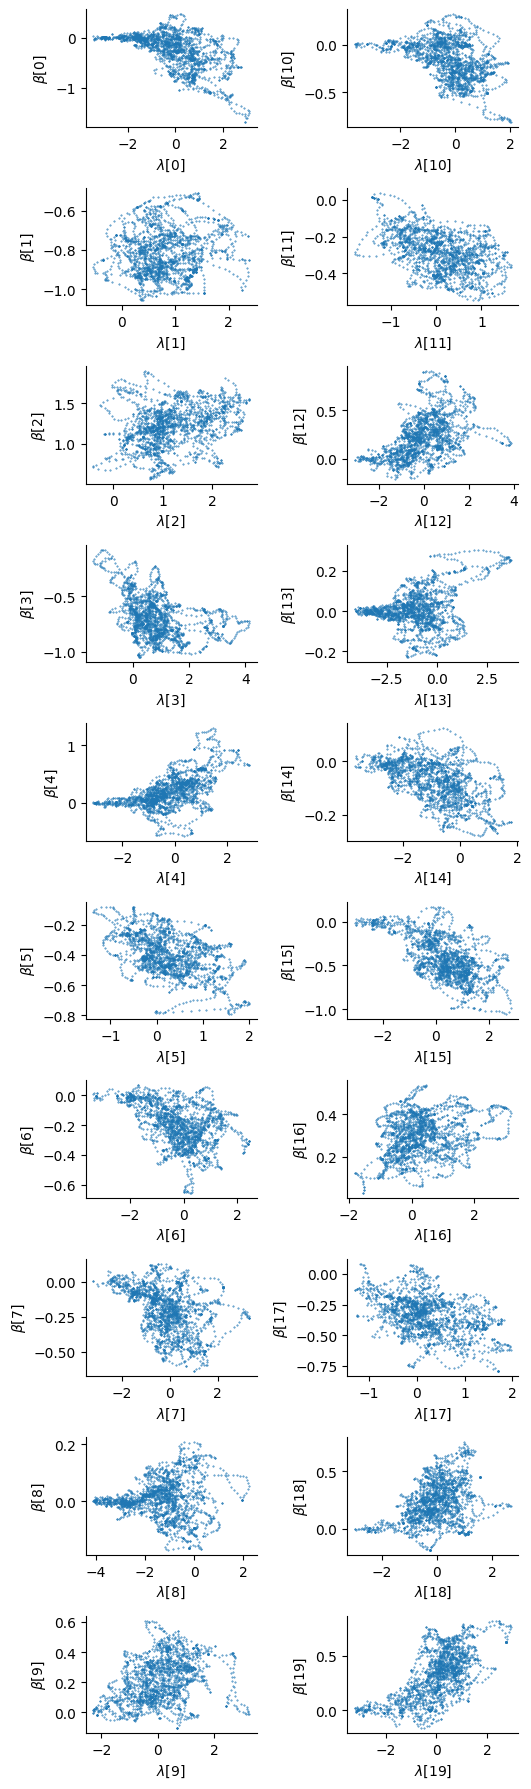

In [12]:
from matplotlib import pylab as plt

import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde

gs = gridspec.GridSpec(10, 3)

fig = plt.figure(figsize=(8, 18))
x = np.linspace(-2., 2., 100)
for i in range(20):
    ax = fig.add_subplot(gs[i%10, i//10])
    ax.plot(samples.position["log_lmbda"][0,:,i], samples.position["beta"][0,:,i], 'o', ms=.4)
    ax.set_xlabel(rf"$\lambda$[{i}]")
    ax.set_ylabel(rf"$\beta$[{i}]")
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
fig.tight_layout()

While some parameters (for instance the 15th) exhibit no particular correlations, the funnel geometry can still be observed for a few of them (4th, 13th, etc.). Ideally one would adopt a centered parametrization for those parameters to get a better approximation to the true posterior distribution, but here we also assess the ability of the sampler to explore these funnel geometries.

We can convince ourselves that the Horseshoe prior induces sparsity on the regression coefficients by looking at their posterior distribution:

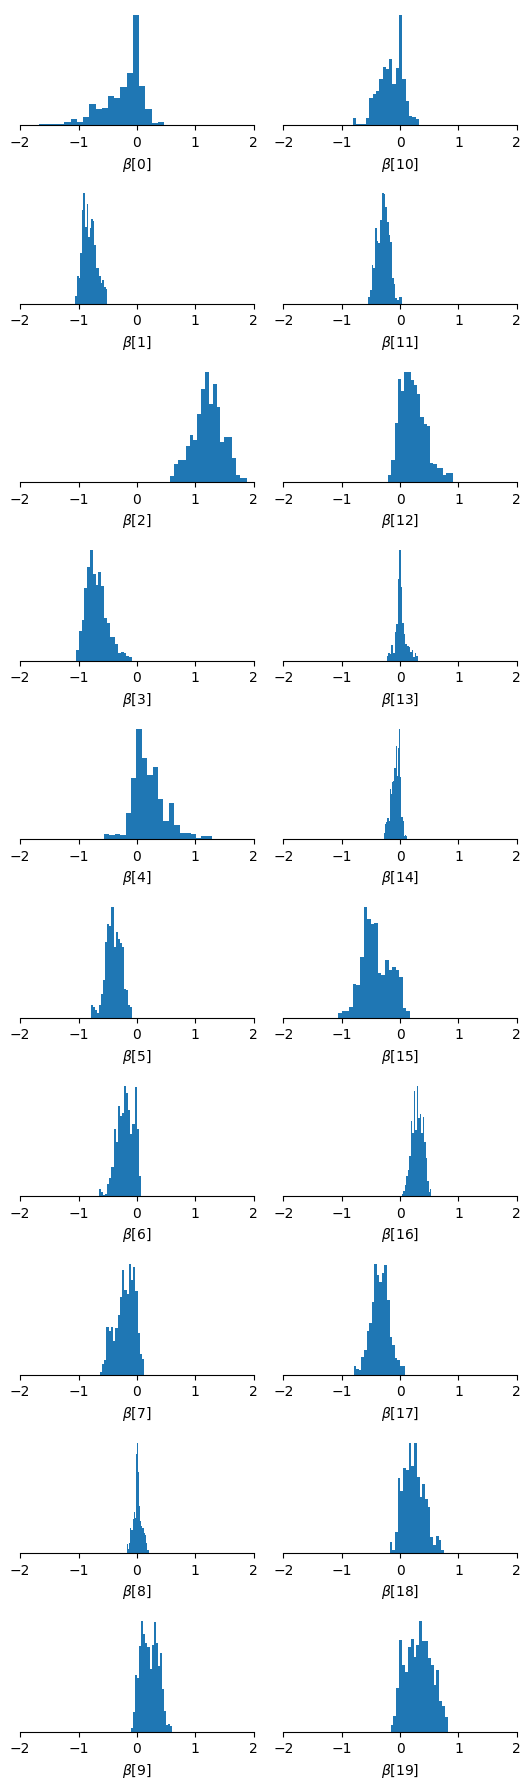

In [13]:
from matplotlib import pylab as plt
import matplotlib.gridspec as gridspec

gs = gridspec.GridSpec(10, 3)

fig = plt.figure(figsize=(8, 18))
x = np.linspace(-2., 2., 100)
for i in range(20):
    ax = fig.add_subplot(gs[i%10, i//10])
    ax.hist(np.array(samples.position["beta"][0, :, i]), bins=20)
    ax.set_xlabel(rf"$\beta$[{i}]")

    ax.set_xlim([-2, 2])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.spines["left"].set_visible(False)
fig.tight_layout()

Indeed, many of the parameters are centered around $0$.

```{note}
It is interesting to notice that the interactions for the parameters with large values do not exhibit funnel geometries.
```

## Bibliography

```{bibliography}
:filter: docname in docnames
```